In [18]:
################## Removing all the heaviside functions in the RD eqns 

import numpy as np
from matplotlib import pyplot, cm
%matplotlib inline

from tqdm import tqdm
import time

import sys
np.set_printoptions(threshold=sys.maxsize)

# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [19]:
g0=4            #Bacterial growth Parameter
gamma=16        #Bacterial growth Parameter
k_value=42.5    #Bacterial growth Parameter

Dc=1e-3     #Diffusion Coefficient of Nutrient 
Db=.04      #Diffusion Coefficient of Bacterial Colony dispersion

t_ref=20    #Reference time (time when death of bacterial cells initiate)
Xe=.3       #Cut-off population density

X0=1e-3     #Reference population density for demarcating colony boundary

C0=15       #Initial nutrient concentration (15g/L)
C_thresh_value=1.5

d=20 #separation between inoculum change; check for 5mm, 10mm, 20mm
rho=2.5
mu=40

dx=dy = 0.25

print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

gridx,gridy=179,179    # should be odd numbers, keep both numbers equal e.g. 369,369 as per paper
dx=0.25*(369/gridx)
dy=0.25*(369/gridy)

Current time is: Fri Nov 22 12:07:35 2019


In [20]:
X1=np.zeros((gridx,gridy),dtype=np.float64)   # 2-D array 
X2=np.zeros((gridx,gridy),dtype=np.float64)
C=np.zeros((gridx,gridy),dtype=np.float64)
m=np.zeros((gridx,gridy))
C_thresh=np.zeros((gridx,gridy))
k=np.zeros((gridx,gridy))

#(taking x,y for coordinate positions) :
x=np.linspace(-int(gridx/2),int(gridx/2),num=gridx,dtype=int)  #grid positions --> e.g. for 369 grids, numbering would be -184,-183,..,0,..,183,184
y=np.linspace(-int(gridy/2),int(gridy/2),num=gridy,dtype=int)  
x0=np.where(x==0)[0][0]   # x-coordinate of position of Origin 
y0=np.where(y==0)[0][0]
xl=np.linspace(-184*.25,184*.25,num=len(x))      # x-coordinate of each grid point (gives distance from origin in x direction)       
yl=np.linspace(-184*.25,184*.25,num=len(y))

############# Defining Initial Conditions #############
# for X1 and X2
for i in range(len(xl)):
    for j in range(len(yl)):
        if  ((xl[i]-d/2)**2 + yl[j]**2 <= rho**2):
            X1[i,j] = X0
        
        if  (xl[i]+d/2)**2 + yl[j]**2 <= rho**2:
            X2[i,j] = X0


                                                                       #np.savetxt('output.txt',X1,fmt='%.4e')

#Initializing parameters in array for all positional coordinates on 2D grid:
for i in range(len(x)):
    for j in range(len(y)):
        C[i,j]=C0
        C_thresh[i,j]=C_thresh_value
        k[i,j]=k_value



print("Initializing Initial Conditions has been completed")
#######################################################        
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

Initializing Initial Conditions has been completed
Current time is: Fri Nov 22 12:07:35 2019


In [21]:
#def H_t(var,value):        # heavy side step function for time & Xe, not for matrix output
    # if var-value <0:
        # return 0
    # if var-value==0:
        # return 0.5
    # else: return 1

    
# def H_pos(mat1,mat2):      # heavy side step function for position, for matrix output of heavy side function values at each grid point
    
    # mat3=np.zeros((max(mat1.shape),min(mat1.shape)))
    
    # for i in range(max(mat1.shape)):
        # for j in range(min(mat1.shape)):
            # if mat1[i,j]-mat2[i,j]<0:
                # mat3[i,j]=0
            # if mat1[i,j]-mat2[i,j]==0:
                # mat3[i,j]=0.5
            # else: mat3[i,j]=1
    # return mat3

# def H_xe(Xe,mat2):      # heavy side step function for position, for matrix output of Mortality term which only activates at Origin
   
    # mat3=np.zeros((mat2.shape[0],mat2.shape[1]))
    
    # if Xe-mat2[0,0] < 0:
            # mat3[int(mat3.shape[0]/2),int(mat3.shape[0]/2)]=0
    # if Xe-mat2[0,0] == 0:
             # mat3[int(mat3.shape[0]/2),int(mat3.shape[0]/2)]=0.5
    # if Xe-mat2[0,0] > 0:
            # mat3[int(mat3.shape[0]/2),int(mat3.shape[0]/2)]=1
    # return mat3


def growth(nt,time_length):  # to be given number of time steps
    
    # nt : number of time-steps -- to be made 5001
    # time_length in hours: duration of time upto which you wish to see the simulation --- to be made 48 hours

    dt=time_length/nt       # time-step size
    print("The growth for time by time step %f for %f hour time length has been completed for:-" %(dt,time_length))
    
    sigma=Db*dt*((1/dx**2)+(1/dy**2))   #Stability Condition
    print("Value of sigma is %f" %sigma)
    if sigma <0.5:
        print("Sigma is less than 0.5, so, solution would be STABLE")
    else: print("Sigma is not less than 0.5, so, solution would be UNSTABLE")
    
    for n in range(nt):
        
        g_c=g0*np.divide(C,np.add(k,C))
        
        ## CAUTION: Removing Heaviside Function in m(t) is now going to imply that the mortality term is active throughout the domain all the time (at all positions where both X1 and X2 are present)
        m[:,:]=mu*np.multiply(X1[:,:],X2[:,:])
        X1[1:-1,1:-1]=X1[1:-1,1:-1]+dt*((np.multiply(g_c[1:-1,1:-1],X1[1:-1,1:-1]))+Db*(((X1[2:,1:-1]-2*X1[1:-1,1:-1]+X1[:-2,1:-1])/dx**2) + ((X1[1:-1,2:]-2*X1[1:-1,1:-1]+X1[1:-1,:-2])/dy**2)) - m[1:-1,1:-1])
        X2[1:-1,1:-1]=X2[1:-1,1:-1]+dt*((np.multiply(g_c[1:-1,1:-1],X2[1:-1,1:-1]))+Db*(((X2[2:,1:-1]-2*X2[1:-1,1:-1]+X2[:-2,1:-1])/dx**2) + ((X2[1:-1,2:]-2*X2[1:-1,1:-1]+X2[1:-1,:-2])/dy**2)) - m[1:-1,1:-1])
        
        C[1:-1,1:-1]= C[1:-1,1:-1] +dt*(-gamma*(np.multiply(g_c[1:-1,1:-1],np.add(X1[1:-1,1:-1],X2[1:-1,1:-1]))) + Dc*(((C[2:,1:-1]-2*C[1:-1,1:-1]+C[:-2,1:-1])/dx**2) + ((C[1:-1,2:]-2*C[1:-1,1:-1]+C[1:-1,:-2])/dy**2)))

        ############# Start: Boundary Conditions ######################
        
        #Neumann Condition: Normal component of Bacterial density on boundary is zero
        
        X1[:][-1] = X1[:][-2]
        X1[:][0]  = X1[:][1] 
        X1[-1][:] = X1[-2][:]
        X1[0][:]  = X1[1][:] 

        X2[:][-1] = X2[:][-2]
        X2[:][0]  = X2[:][1] 
        X2[-1][:] = X2[-2][:]
        X2[0][:]  = X2[1][:] 

        
        
        #Dirichlet condition: Fixed and Unchanging Concentration of growth media on boundary
        C[0][:]=C[-1][:]=C[:][0]=C[:][-1]=C0
        
        ############# End: Boundary Conditions ######################

        ############ Start: Saving history of Bacterial Density and Growth Media Concentration #########
        
        X1_hist[n+1][:][:]=X1[:][:]
        X2_hist[n+1][:][:]=X2[:][:]
        C_hist[n+1][:][:]=C[:][:]
        
        ############ End: Saving history of Bacterial Density and Growth Media Concentration #########
        
            
        if n%100==0:
            print("%d steps, Wall clock time: "  %n, end="")
            print(time.asctime( time.localtime(time.time())))
        
        
nt=5001     # number of time steps
#sigma=1   # Enter the value of stability parameter ( <0.5 for stable, >=0.5 for unstable)
#dt=sigma * ( 1/((1/dx**2)+(1/dy**2)) ) * (1/Db)

#time_length= nt*dt 
time_length=48     # 48 hr simulation was carried out in paper

X1_hist=np.zeros((nt+1,gridx,gridy))
X2_hist=np.zeros((nt+1,gridx,gridy))
C_hist=np.zeros((nt+1,gridx,gridy))

X1_hist[0][:][:]=X1[:][:]
X2_hist[0][:][:]=X2[:][:]
C_hist[0][:][:]=C[:][:]

growth(nt,time_length)

print("All the step calculations for growth have been completed for total steps %d" %nt)  
print("Wall clock time: " ,end="")
print(time.asctime( time.localtime(time.time())))

The growth for time by time step 0.009598 for 48.000000 hour time length has been completed for:-
Value of sigma is 0.002891
Sigma is less than 0.5, so, solution would be STABLE
0 steps, Wall clock time: Fri Nov 22 12:07:36 2019
100 steps, Wall clock time: Fri Nov 22 12:07:37 2019
200 steps, Wall clock time: Fri Nov 22 12:07:38 2019
300 steps, Wall clock time: Fri Nov 22 12:07:39 2019
400 steps, Wall clock time: Fri Nov 22 12:07:40 2019
500 steps, Wall clock time: Fri Nov 22 12:07:41 2019
600 steps, Wall clock time: Fri Nov 22 12:07:42 2019
700 steps, Wall clock time: Fri Nov 22 12:07:43 2019
800 steps, Wall clock time: Fri Nov 22 12:07:44 2019
900 steps, Wall clock time: Fri Nov 22 12:07:45 2019
1000 steps, Wall clock time: Fri Nov 22 12:07:46 2019
1100 steps, Wall clock time: Fri Nov 22 12:07:47 2019
1200 steps, Wall clock time: Fri Nov 22 12:07:48 2019
1300 steps, Wall clock time: Fri Nov 22 12:07:49 2019
1400 steps, Wall clock time: Fri Nov 22 12:07:50 2019
1500 steps, Wall clock t

Plotting figures for X1 & X2 growth
0
454
909
1363
1818
2272
2727
3181
3636
4090
4545
5000
Current time is: Fri Nov 22 12:17:34 2019


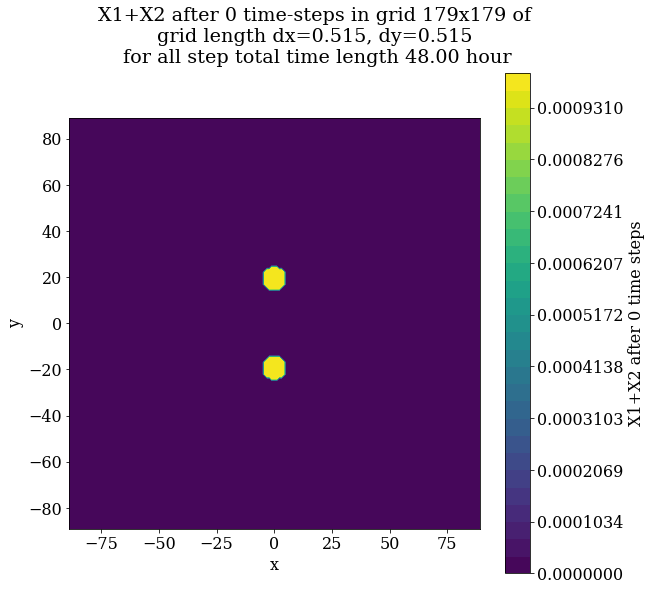

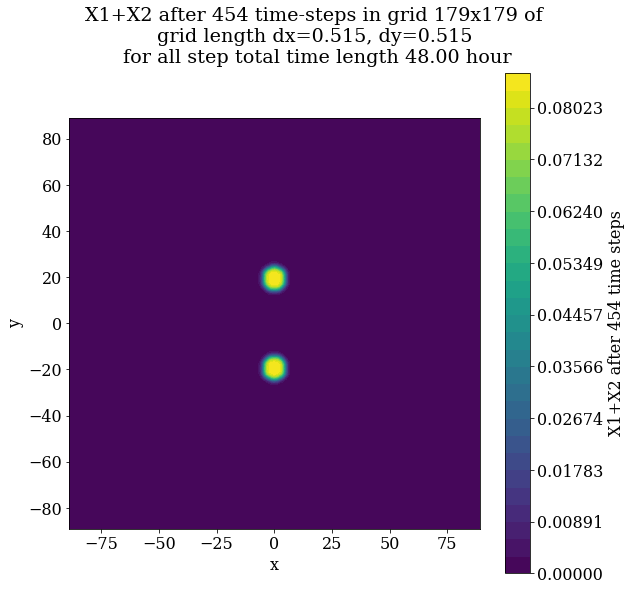

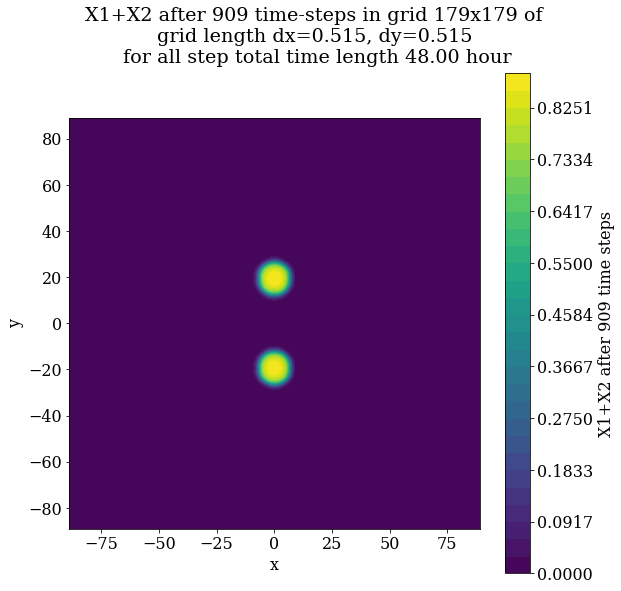

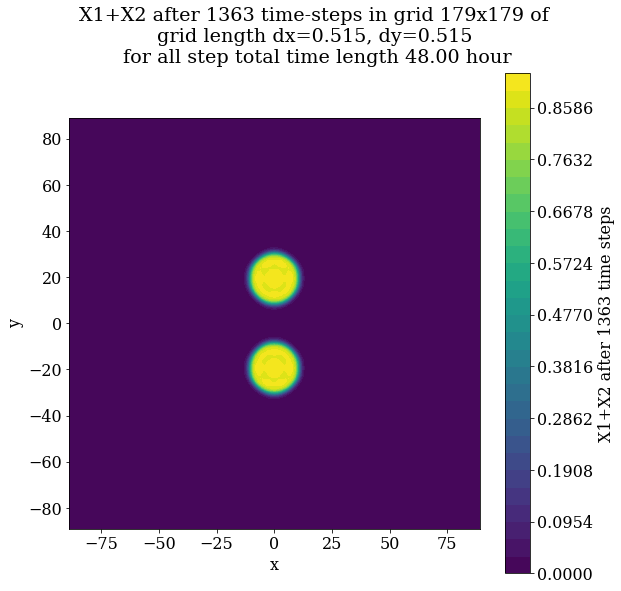

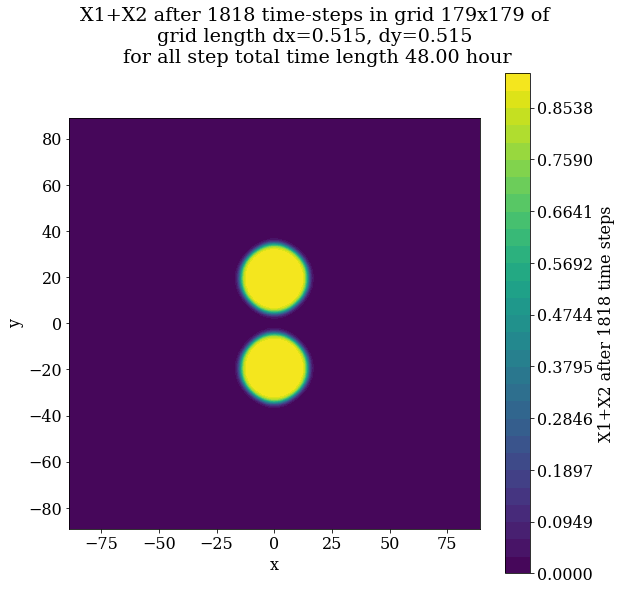

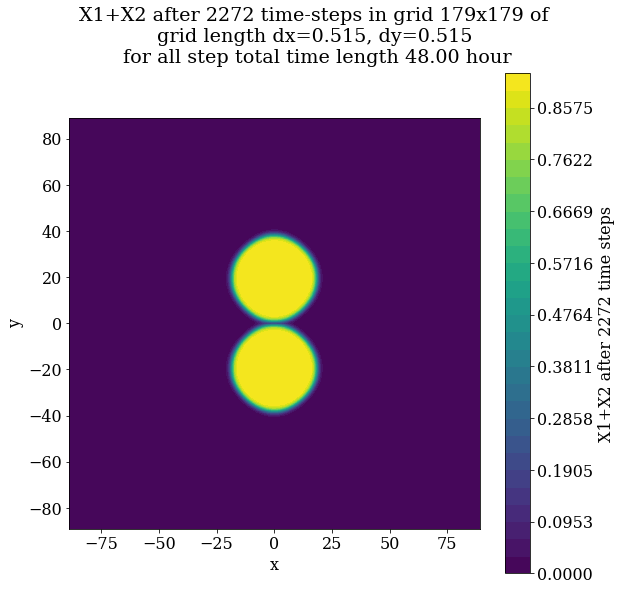

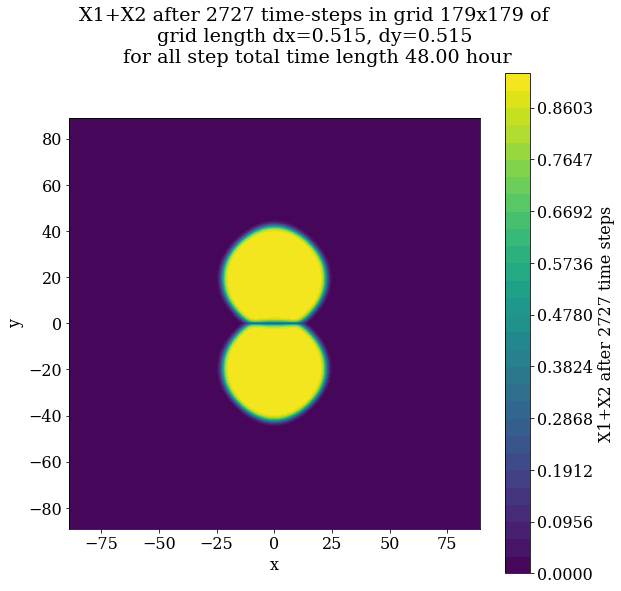

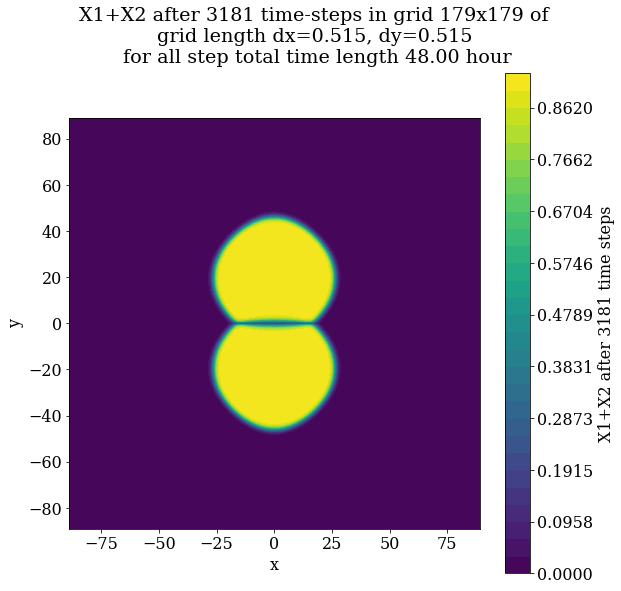

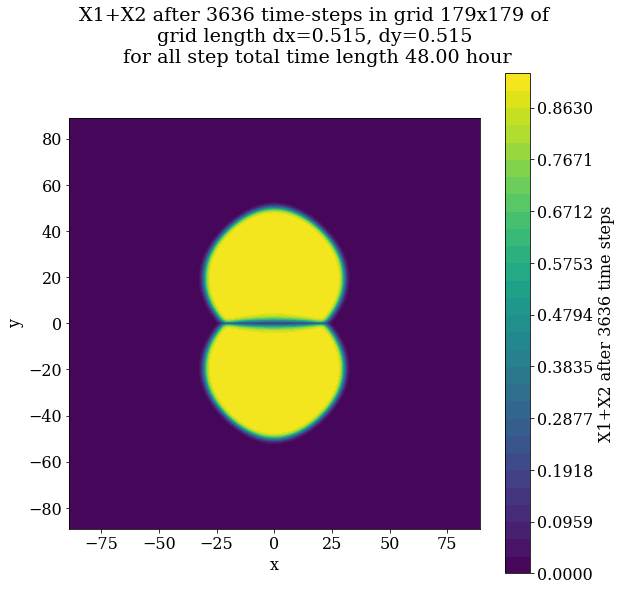

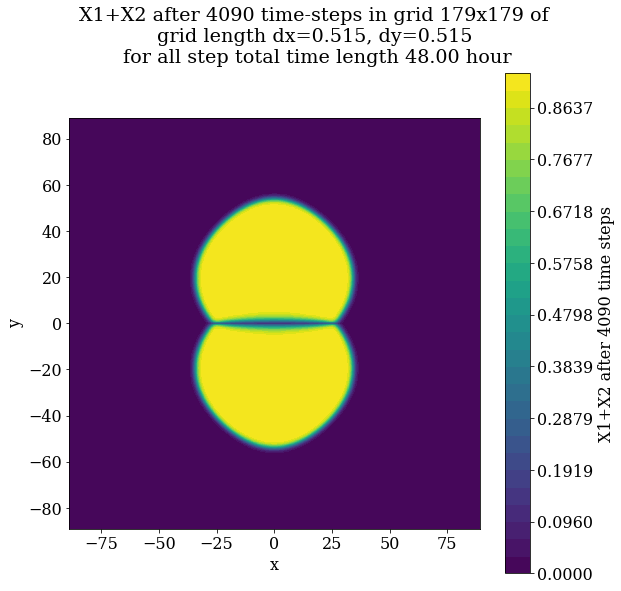

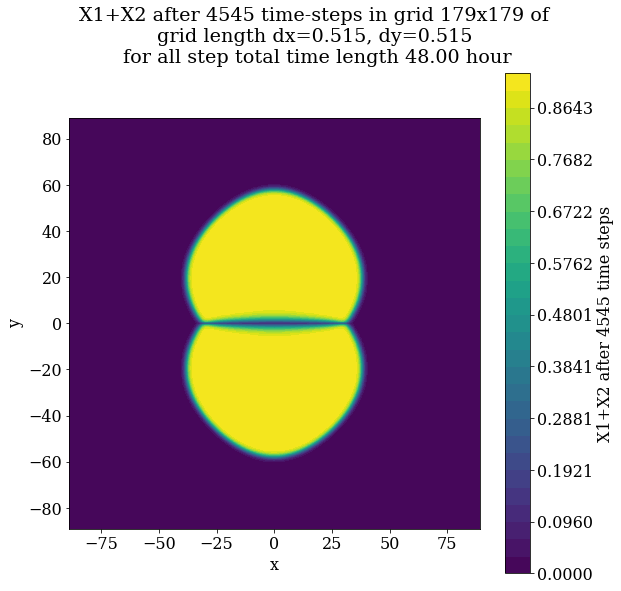

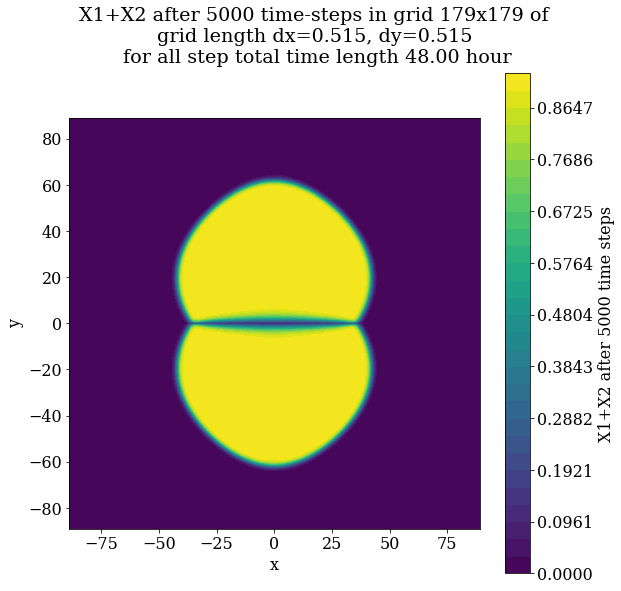

In [24]:
print("Plotting figures for X1 & X2 growth")
for i in np.linspace(0,5000,num=12,dtype=int):
    fig=pyplot.figure(figsize=(9.2,9.2))

    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, np.max(X2_hist[i]+X1_hist[i]), num=30) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, X2_hist[i]+X1_hist[i], levels=levels)
    fig.suptitle('X1+X2 after %d time-steps in grid %dx%d of \ngrid length dx=%.3f, dy=%.3f \nfor all step total time length %.2f hour' %(i,gridx,gridy,dx,dy,time_length) )
    cbar = pyplot.colorbar(contf)
    cbar.set_label('X1+X2 after %d time steps' %i)
    pyplot.axis('scaled', adjustable='box')
    
    fig.savefig('X1 n X2 %d.jpg'%i)
    
    print(i)
    ;
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))


In [25]:
import winsound
duration = 3000  # milliseconds
freq = 484  # Hz
winsound.Beep(freq, duration)